Aalen’s additive hazards model
--------------

### Introduction

Aalen’s additive hazards (AAH) model [[1]](#refer-1) is a statistical model used to analyze the time-to-event data, such as the survival of patients with a certain disease or the failure time of mechanical systems. Like the Cox's proportional hazards (CoxPH) model, it studies the risk factors which affect the survival time and their risk contributions. Instead of multiplicative like the CoxPH model, the AAH model is additive. And it also offers great flexibility due to its semi-parametric form. 

The AAH model specifies the hazard rate $\lambda(t)=\underset{h\to 0}{\lim}\frac{P(T\leq t+h)}{P(T>t)}$ for the survival time $T$ associated with a $p$-vector of possibly time-varying covariates $\mathbf{Z}(\cdot)$, and taking the form 
$$\lambda(t\mid \mathbf{Z})=\lambda_0(t)+\boldsymbol{\beta}^{\prime}\mathbf{Z}(t),$$
where $\boldsymbol{\beta}$ is $p$-vector of regression parameters and $\lambda_0(\cdot)$ is baseline hazard function. The characteristic of AAH model is that the influence of each covariate is separate.

For many reasons not all survival time are fullly observed, we only consider the right-censoring situation here and let $C$ be the censoring time. Denote the observed time by $X=\min\{T,C\}$ and the censoring indicator by $\delta=I(T\leq C)$. Define the observed-failure counting process $N(t)=I(X\leq t,\delta=1)$ which registers whether an uncensored failure has occurred by time $t$ and the corresponding at-risk indicator $Y(t)=I(X\geq t)$. Without loss of generality, denote 1 as the terminal time of observation and there are $n$ independent data $\{(X_i,\delta_i,\mathbf{Z}_i): i=1,2,\cdots,n\}$.

The least squares-type loss function of AAH model is 
$$L_1(\boldsymbol{\beta})=\frac{1}{2}\boldsymbol{\beta}^{\prime}V\boldsymbol{\beta}-\mathbf{b}^{\prime}\boldsymbol{\beta},$$
where $\overline{\mathbf{Z}}(t)=\sum_{j=1}^n Y_j(t) \mathbf{Z}_j(t) / \sum_{j=1}^n Y_j(t)$, $\mathbf{b}=\frac{1}{n}\sum_{i=1}^{n}\int_0^1 \mathbf{Z}_i(t)-\overline{\mathbf{Z}}(t) \mathrm{d} N_i(t)$ and $\mathbf{V}=\frac{1}{n} \sum_{i=1}^n \int_0^1 Y_i(t)\left\{\mathbf{Z}_i(t)-\overline{\mathbf{Z}}(t)\right\}^{\otimes 2} \mathrm{d} t$. Parameter $\boldsymbol{\beta}$ is estimated by minimizing the loss function.

### Data generation

The survival probability is defined as $S(t)=P(T>t)$, and the survival probability of AAH model is
$$S(t)=\exp\left\{-\int_0^t \lambda(s\mid \mathbf{Z}) d s\right\}=\exp\left\{-\int_0^t \lambda_0(s)+\boldsymbol{\beta}^{\prime}\mathbf{Z}(s) d s\right\}.$$
In the simulation part, for simplicity, let the baseline hazard function $\lambda_0(t)$ be constant 1 and the covariates be time independent. Thus, the survival time can be generated as follows,
$$T=-\frac{\log U}{1+\boldsymbol{\beta}^{\prime}\mathbf{Z}},$$
where $U$ is uniform on [0,1]. And $\mathbf{Z}$ is generated from multivariate normal distribution with zero mean.

In [177]:
# generate additive hazard model data
import numpy as np
import numpy.random as rd

def make_ahaz_data(n, coef, c=5, rho=0.2):
    lam = 1
    p = coef.shape[0]
    mu = np.zeros(p)
    Sigma = np.power(rho, np.abs(np.linspace(1, p, p) - np.linspace(1, p, p).reshape(p, 1)))
    x = rd.multivariate_normal(mu, Sigma, (10*n,))    # variables
    x = x[np.matmul(x,coef)>-1,]
    x = x[0:n,]

    xcoef = np.matmul(x,coef)
    #lam = np.maximum(1, np.ceil(np.max(-xcoef[xcoef<0])) )
    T = -np.log(rd.uniform(0,1, (n,)))/(lam + xcoef)    # survival time
    U = rd.uniform(0,c, (n,))           # censoring time
    delta = (T<=U)*1           # censoring indicator
    print("censoring rate:", np.sum(1-delta)/n )
    return x, np.minimum(T,U), delta

### Sparse AHH model

Nowadays, high-dimensional data is becoming increasingly common in the biomedical field. When dealing with high-dimensional data, it is necessary to choose appropriate techniques to reduce dimensionality. We focus on sparsity, which means that real non-zero variables are sparse. We can estimate $\boldsymbol{\beta}$ by minimizing least squares-type loss under sparsity constraint:
$$\arg\min_{\beta \in R^p}L_1(\beta) , s.t.  || \beta ||_0 \leq s.$$

Generate 200 subjects using the method described in the above part,  each subjects has ten explanatory variables, of which only two are effective. Then, we visualize the Kaplan-Meier survival curve of 200 subjects.

censoring rate: 0.155


<AxesSubplot: xlabel='timeline'>

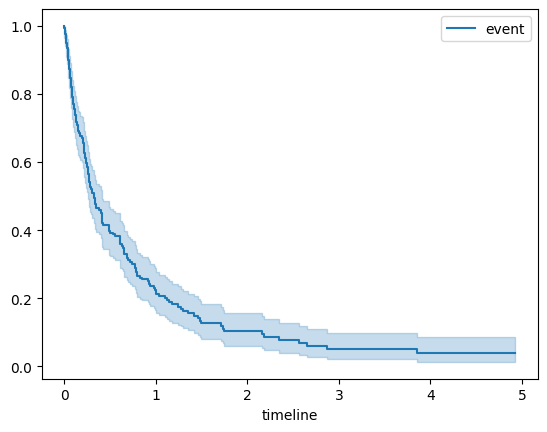

In [179]:
from lifelines import KaplanMeierFitter

# generate data 
np.random.seed(319)
n, p, k = 200, 10, 2
beta = np.zeros(p)
beta[np.linspace(0, p - 1, k, dtype=int)] = [2 for _ in range(k)]
x, y, delta = make_ahaz_data(n,beta,c=5)

# survival probability
kmf = KaplanMeierFitter()
kmf.fit(y, delta, label="event", alpha=0.05)
kmf.plot()

Here is Python code for solving sparse AAH model, which can be done rather directly by implementing the objective function of AAH model and feed it into `ScopeSolver`.   

In [180]:
import jax.numpy as jnp
from skscope import ScopeSolver
import pandas as pd

xsort = x[np.argsort(y),:]
ysort = y[np.argsort(y)]
deltasort = delta[np.argsort(y)]
ydiff = np.append(ysort[0],np.diff(ysort))
xbar = np.empty(shape=(n,p))
for i in range(0,n):
    xbar[i,:] = np.mean(xsort[i:n,:],axis=0)
b = np.matmul(deltasort, xsort-xbar)
V = np.empty(shape=(p,p))
for i in range(n):
    V += ((xsort[i,:]-xbar[0:(i+1),:]).T) @ np.diag(ydiff[0:(i+1)]) @ (xsort[i,:]-xbar[0:(i+1),:])


def ahazard_objective(params):
    return jnp.dot(jnp.dot(V,params),params)/2 - jnp.dot(params,b)

solver = ScopeSolver(p, k)
solver.solve(ahazard_objective, jit=True)
zeroindex = np.where(solver.get_result()["params"]==0)

# save the data as data.frame
data_df = pd.DataFrame(np.hstack((x,np.append(y,delta).reshape(n,2))))
data_df.rename(columns={p:"time",
                        p+1:"event"}, inplace=True)
data_df = data_df.astype({"event":int})
data_df_selected = data_df.drop(columns=zeroindex[0])

print("Estimated parameter:", solver.get_result()["params"], "objective:",solver.get_result()["value_of_objective"])
print("True parameter:", beta, "objective:",ahazard_objective(beta))

Estimated parameter: [1.93507274 0.         0.         0.         0.         0.
 0.         0.         0.         2.13002553] objective: -91.02359008789062
True parameter: [2. 0. 0. 0. 0. 0. 0. 0. 0. 2.] objective: -89.78891


The real variables are selected correctly and the estimated parameters are close to the real values. 

### Comparison: sparse & dense models

The following will show a comparison of the fitting results of the AAH model before and after variable selection.

In [181]:
from lifelines import AalenAdditiveFitter

# model fit with all variables
aaf = AalenAdditiveFitter(fit_intercept=False)
aaf.fit(data_df, duration_col='time', event_col='event')
aaf.print_summary()

<lifelines.AalenAdditiveFitter: fitted with 200 total observations, 98 right-censored observations>
             duration col = 'time'
                event col = 'event'
       number of subjects = 200
number of events observed = 102
         time fit was run = 2023-06-06 03:35:10 UTC

---
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
---
Concordance = 0.53

From the summary table, the estimated coefficients of non-real variables are very small, only the coefficients of real variables are relatively large. 

In [182]:
# model fit with selected variables
aaf_selected = AalenAdditiveFitter(fit_intercept=False)
aaf_selected.fit(data_df_selected, duration_col='time', event_col='event')
aaf_selected.print_summary()

<lifelines.AalenAdditiveFitter: fitted with 200 total observations, 98 right-censored observations>
             duration col = 'time'
                event col = 'event'
       number of subjects = 200
number of events observed = 102
         time fit was run = 2023-06-06 03:35:12 UTC

---
Empty DataFrame
Columns: []
Index: [0, 9]
---
Concordance = 0.56

The concordance score (also known as the c-index) of the fit, which is a generalization of the ROC AUC to survival data. The coefficients estimated by the ``lifeline`` library are less precise than those estimated by the ``scope``, but it is also clear that fitting with the selected variables corresponds to an increase in the concordance score. Therefore, variable selection effectively explains the model without losing too much information.

### Reference

<div id="refer-1"></div>

- [1] Aalen, O.O. (1989), A linear regression model for the analysis of life times. Statist. Med., 8: 907-925. https://doi.org/10.1002/sim.4780080803